## EE512 – Applied Biomedical Signal Processing
# Practical session – Linear Models II
### Instructions
* This notebook provides all the questions of the practical session and the space to answer them. We recommend working directly here and then exporting the document as your report.
* Include any code used when addressing the questions, together with your answers.
* Please submit your report as a single PDF file.
* We recommend working in a group of 4–5 students; you must prepare one single report for the group (`name1_name2_name3_name4_name5_lab_LinearModelsII.pdf`), but every member needs to upload the same file individually.

In [1]:
#%matplotlib widget

# Imports
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import resample, welch, correlate
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.ar_model import AutoReg

# File paths
fhr1 = os.path.join(os.getcwd(), 'data', 'heart_1.dat')
fhr2 = os.path.join(os.getcwd(), 'data', 'heart_2.dat')
fem1 = os.path.join(os.getcwd(), 'data', 'emg1.dat')
fem2 = os.path.join(os.getcwd(), 'data', 'emg2.dat')
fppg = os.path.join(os.getcwd(), 'data', 'ppg.dat')
feeg = os.path.join(os.getcwd(), 'data', 'eeg_stim.dat')

### Experiment 1: parametric spectral estimation of cardiorespiratory signals
The file `/data/heart_1.dat` contains three physiological signals: RR-interval, arterial pressure and respiration, in this order (sampled at 4 Hz). The recordings were made in a patient at rest. In the spectral domain, this RR-interval signal is expected to show a peak around 0.08 Hz, corresponding to the *baroreflex* (regulation between arterial blood pressure and heart rate), and a peak at 0.225 Hz, corresponding to the *breathing rate* (heart rhythm modulation by respiration, the so-called *“sinus arrhythmia”*) – see `/data/readme_heart.txt` for more details.

We start by importing the signals, subsampling to 1 Hz, and removing their averages:

In [2]:
with open(fhr1, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    rr1 = np.array([float(s[0]) for s in txt])
    bp1 = np.array([float(s[1]) for s in txt])
    rs1 = np.array([float(s[2]) for s in txt])

df = 4
rr1 = resample(rr1, int(len(rr1)/df))
bp1 = resample(bp1, int(len(bp1)/df))
rs1 = resample(rs1, int(len(rs1)/df))

for y in [rr1, bp1, rs1]:
    y -= np.mean(y)

AR modeling provides tools for extracting various useful estimates from a signal, in a so-called *parametric* way, because the estimates are based on the model parameters, rather than on the raw signal itself. The function defined below implements the estimation of the signal spectral density based on its AR parameters.

In [3]:
def ar_psd(arg1, arg2, arg3, n=1000):
    """
    Parametric spectral density estimation based on AR modeling
    
    Inputs:
        arg1: ?
        arg2: ?
        arg3: ?
        n: defines the spectral sampling
    
    Outputs:
        arg4: ?
        arg5: ?
    """
    
    arg5 = np.arange(n) * arg3/2/n
    aar, sg = yule_walker(arg1, order=arg2, method="mle")
    
    a = complex(1)
    for k in range(1,arg2+1):
        a += -aar[k-1] * np.exp(-2*np.pi*k*1j*arg5/arg3)
    
    arg4 = sg**2 / (arg3 * np.abs(a)**2)
    
    return arg4, arg5

**Question 1.1.** The implementation above has an incomplete docstring (help text), and the input and output arguments have generic names (`arg1-5`). Copy the function to the answer space below, complete the help, and replace the argument names by more intuitive choices, based on what you've learned in the theory.

**Answer 1.1.**

In [4]:
def ar_psd(x, p, f_s, n=1000):
    """
    Parametric spectral density estimation based on AR modeling
    
    Inputs:
        x: input sequence whose spectral density is to be estimated
        p: order of the auto-regressive model
        f_s: sampling frequency [Hz]
        n: defines the spectral sampling
    
    Outputs:
        P: power spectral density of the estimated AR process
        f: frequencies [Hz]
    """
    
    f = np.arange(n) * f_s/2/n
    aar, sg = yule_walker(x, order=p, method="mle")
    
    a = complex(1)
    for k in range(1,p+1):
        a += -aar[k-1] * np.exp(-2*np.pi*k*1j*f/f_s)
    
    P = sg**2 / (f_s * np.abs(a)**2)
    
    return P, f

#### We now use this tool to obtain the spectral density of the three signals. Below, we explore the results obtained with different AR model orders: 5, 15, 40.

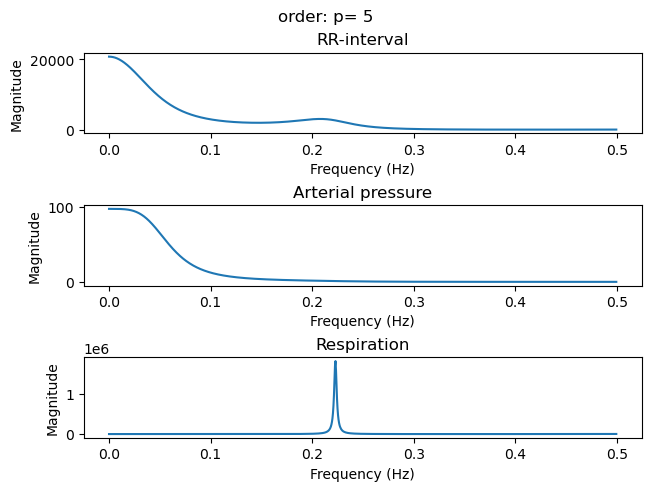

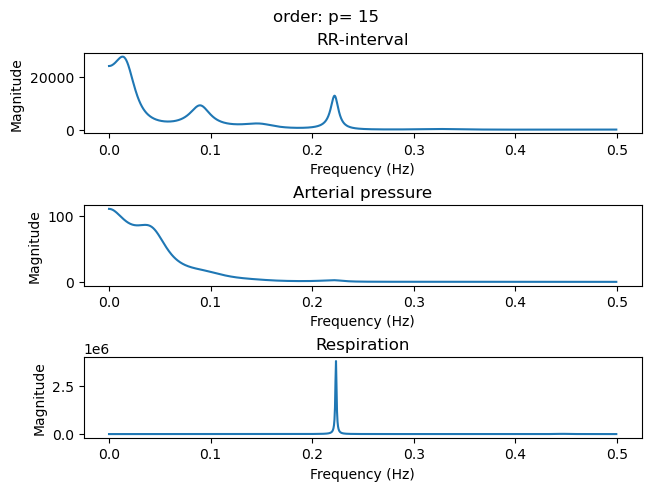

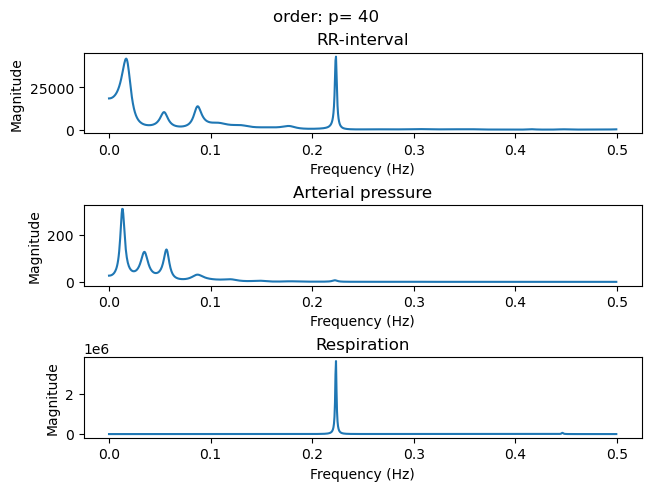

In [5]:
y = [rr1, bp1, rs1]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']

for p in (5, 15, 40):
    
    plt.figure(constrained_layout=True)
    
    for k in range(3):
        
        py, f = ar_psd(y[k], p, 1.0)
        plt.subplot(3,1,k+1)
        plt.plot(f, py)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(ttl[k])
        plt.suptitle(f"order: p= {p}")

**Question 1.2.** How does the order affect the spectra? Given the physiological description of the expected peaks for the RR-interval, what is the most suitable order choice?

**Answer 1.2.** The order increases the frequency resolution.
We expect the RR-interval to have a peak at 0.08 Hz and 0.225 Hz. Hence, the order $p=5$ is clearly insufficient to reveal those peaks. The order $p=40$ has additional peaks, which could be artifacts, while the order $p=15$ is sufficient.

We can now perform a *non-parametric* spectral estimation of the same signals, using for instance Welch’s method:

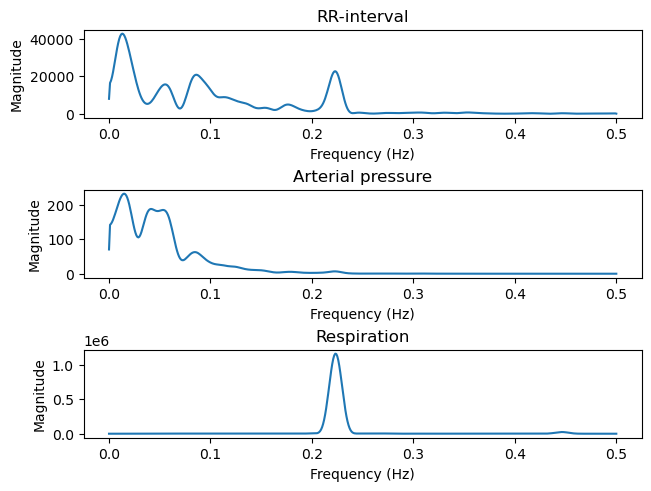

In [6]:
y = [rr1, bp1, rs1]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']

plt.figure(constrained_layout=True)

for k in range(3):
    
    f, py = welch(y[k], fs=1.0, nperseg=100, scaling='density', nfft=1000)
    
    plt.subplot(3,1,k+1)
    plt.plot(f, py)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(ttl[k])

**Question 1.3.** Explain how Welch's method works (it may be helpful to consult the help of `welch`), and the fundamental differences between this approach and the AR parametric method.

In [7]:
welch?

Signature:
welch(
    x,
    fs=1.0,
    window='hann',
    nperseg=None,
    noverlap=None,
    nfft=None,
    detrend='constant',
    return_onesided=True,
    scaling='density',
    axis=-1,
    average='mean',
)
Docstring:
Estimate power spectral density using Welch's method.

Welch's method [1]_ computes an estimate of the power spectral
density by dividing the data into overlapping segments, computing a
modified periodogram for each segment and averaging the
periodograms.

Parameters
----------
x : array_like
    Time series of measurement values
fs : float, optional
    Sampling frequency of the `x` time series. Defaults to 1.0.
window : str or tuple or array_like, optional
    Desired window to use. If `window` is a string or tuple, it is
    passed to `get_window` to generate the window values, which are
    DFT-even by default. See `get_window` for a list of windows and
    required parameters. If `window` is array_like it will be used
    directly as the window and its lengt

**Answer 1.3.** Welch's method first splits the signal into overlapping segments. Each segment has a window applied to it, and the periodogram is then computed as the squared magnitude of the discrete Fourier transform. The periodograms are then averaged to form an estimate of the power spectral density.

The fundamental difference with the AR parametric method is that the latter does not perform any kind of averaging between segments of the signal, as the AR model is computed from the entire signal. In addition, Welch's method may introduce artifacts due to the windowing of the signal.

**Question 1.4.** In our particular problem, how do the spectra obtained with Welch's method compare with those of the parametric approach (order 15)? Given the previous RR-interval description, which approach performs most reliably?

**Answer 1.4.** The parametric approach seem to perform more reliably, as the peaks at the known frequencies 0.08Hz and 0.225Hz are narrower. Furthermore, the spectra obtained with Welch's method has additional oscillations that could originate from the windowing.

We now consider the signals in `/data/heart_2.dat`, which are recordings from the same individual after alcohol consumption.

In [8]:
with open(fhr2, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    rr2 = np.array([float(s[0]) for s in txt])
    bp2 = np.array([float(s[1]) for s in txt])
    rs2 = np.array([float(s[2]) for s in txt])

df = 4
rr2 = resample(rr2, int(len(rr2)/df))
bp2 = resample(bp2, int(len(bp2)/df))
rs2 = resample(rs2, int(len(rs2)/df))


**Question 1.5.** Repeat the processing steps done for `heart_1.dat` to obtain a parametric spectral estimation (order 15). Which of the physiological mechanisms described for the RR-interval was most disrupted by alcohol? And what other changes do you observe in the physiological signals?

**Answer 1.5.** We notice that the frequency of 0.08Hz is completely attenuated, hence we assume that the baroreflex is signifcantly disrupted by alcohol. Additionally, we notice that a peak frequency of 0.225 Hz in arterial pressure has appeared with alcohol.

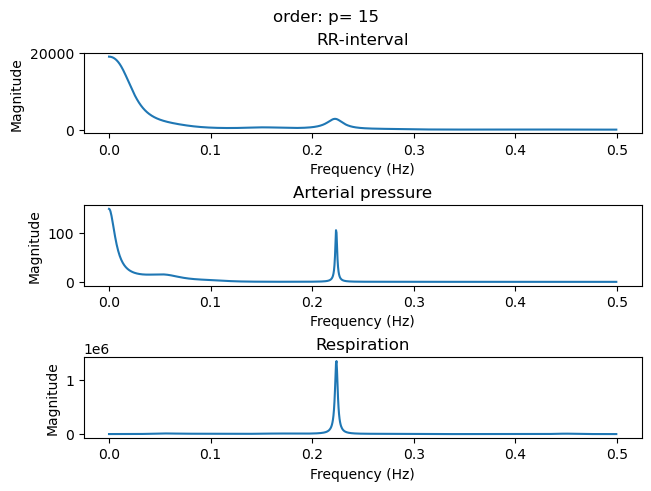

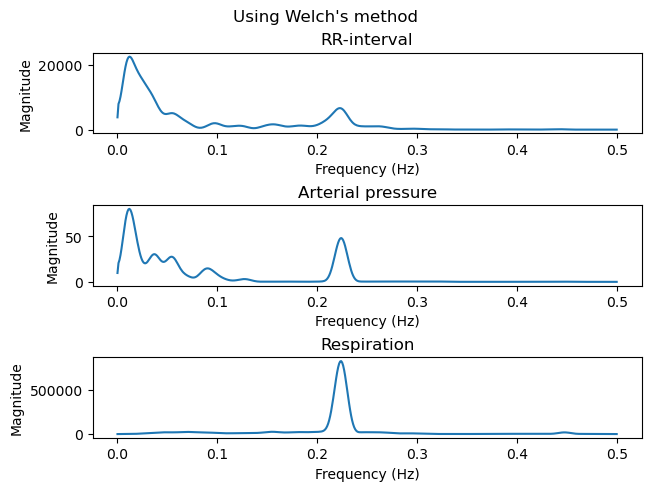

In [9]:
for y in [rr2, bp2, rs2]:
    y -= np.mean(y)

y = [rr2, bp2, rs2]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']

for p in [15]:
    
    plt.figure(constrained_layout=True)
    
    for k in range(3):
        
        py, f = ar_psd(y[k], p, 1.0)
        
        plt.subplot(3,1,k+1)
        plt.plot(f, py)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(ttl[k])
        plt.suptitle(f"order: p= {p}")
    

plt.figure(constrained_layout=True)

for k in range(3):
    
    f, py = welch(y[k], fs=1.0, nperseg=100, scaling='density', nfft=1000)
    
    plt.subplot(3,1,k+1)
    plt.plot(f, py)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(ttl[k])
    plt.suptitle("Using Welch's method")

### Experiment 2: estimating the effects of fatigue on muscle signals
The files `/data/emg1.dat` and `/data/emg2.dat` contain three surface electromyography (sEMG) signals each (1024 Hz sampling frequency). These signals were recorded from the thigh muscle during a 10-min exercise on an ergocycle, respectively from an athlete (`emg1`) and from a moderately trained subject (`emg2`). In each file, the columns correspond to recordings from the *start*, *middle* and *end* of the exercise, respectively.

We start by importing the signals:

In [67]:
with open(fem1, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    em1 = np.zeros((n,3))
    for k in range(3):
        em1[:,k] = [float(s[k]) for s in txt]

with open(fem2, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    em2 = np.zeros((n,3))
    for k in range(3):
        em2[:,k] = [float(s[k]) for s in txt]

fs = 1024.0 # Hz

We first plot the sEMG segments in the time domain. We can observe four bursts in each recording, which correspond to four pedal strokes. The goal of the experiment was to assess the effects of fatigue on the signal properties of the sEMG.

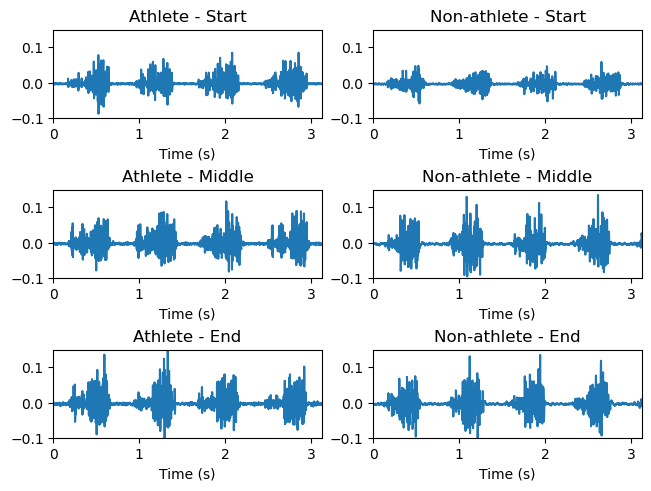

In [68]:
ttl1 = ['Athlete', 'Non-athlete']
ttl2 = ['Start', 'Middle', 'End']
t = np.arange(n) / fs

plt.figure(constrained_layout=True)
for k in range(2):
    
    y = [em1, em2][k]
    
    for l in range(3):
        
        plt.subplot(3,2,2*l+k+1)
        plt.plot(t,y[:,l])
        plt.xlim(t[0], t[-1])
        plt.ylim(-0.10, 0.15)
        plt.xlabel('Time (s)')
        plt.title(ttl1[k] + ' - ' + ttl2[l])

We'll now look at the spectral profile of the signals. Considering, for instance, the start sEMG recording of the athlete, we obtain the parametric power spectral density (PSD) for an AR model of order 30:

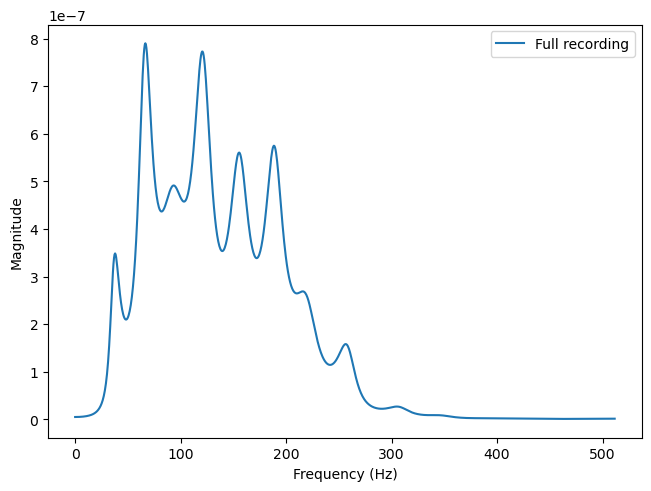

In [69]:
p = 30
pya, fa = ar_psd(em1[:,0], p, fs)

plt.figure(constrained_layout=True)
plt.plot(fa, pya, label='Full recording')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()

**Question 2.1.** In principle, it would be more correct to segment each burst and analyze it separately, but it turns out that using the entire recording will yield a relatively similar spectral profile. Check that it is the case: copy the plotting code above to the space below and add (overlayed in the same panel) the PSD obtained from the first burst only, for the same signal. How do their profiles compare? Where does the difference in peak signal-to-noise come from?

**Answer 2.1.** 

Their profiles are similar in shape, but the peaks in the PSD of the single burst is more noticeable : this is due to the fact that when considering the full recording, we are taking into account the parts where the athlete is pedaling, and this increases the difference in peak signal-to-noise.

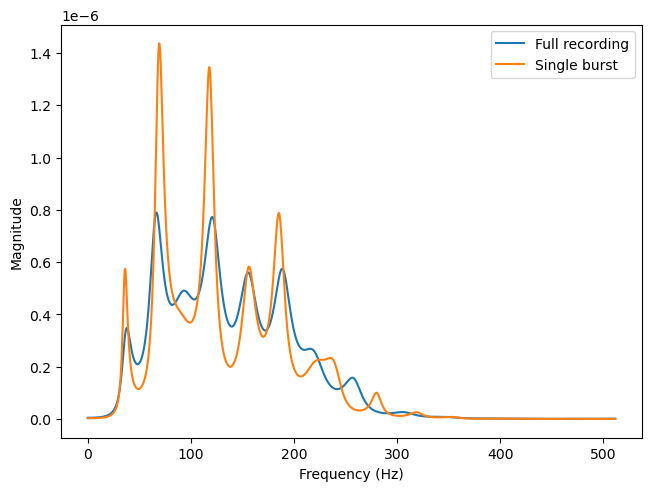

In [70]:
p = 30
pya, fa = ar_psd(em1[:,0], p, fs)
pya_burst, fa_burst = ar_psd(em1[:800,0], p, fs)

plt.figure(constrained_layout=True)
plt.plot(fa, pya, label='Full recording')
plt.plot(fa_burst, pya_burst, label="Single burst")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()

We now estimate and plot the PSD for every recorded segment of both individuals:

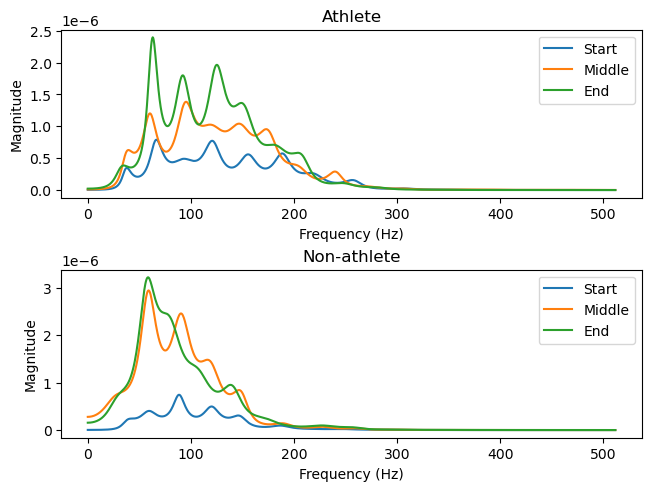

In [71]:
mean_freq = np.zeros((3,2))
plt.figure(constrained_layout=True)
for k in range(2):
    
    y = [em1, em2][k]
    plt.subplot(2,1,k+1)
    
    for l in range(3):
        
        pya, fa = ar_psd(y[:,l], p, fs)
        mean_freq[l,k] = sum(fa * pya / sum(pya))
        plt.plot(fa, pya, label=ttl2[l])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
    
    plt.title(ttl1[k])
    plt.legend()

**Question 2.2.** To complement the above PSD's, estimate the mean frequency using `sum(fa * pya / sum(pya))`. What does this formula express?

In [72]:
import pandas as pd

mean_freq_df = pd.DataFrame(mean_freq, columns=ttl1, index= ttl2)

mean_freq_df

,Athlete,Non-athlete
Start,136.507388,106.295477
Middle,127.307365,87.906964
End,121.096116,87.613740


**Answer 2.2.** 

This formula is a weighted average of the PSD over each frequency that's normalized by the sum of the whole PSD. 

**Question 2.3.** Based on the PSD plots and the mean frequencies obtained above, what marks the difference between the athlete and the moderately trained subject?

**Answer 2.3.**
We can observe that the mean frequency decreases in both cases, but it happens more drastically for the non-athlete, meaning that more fatigue is accumulated in this case.

### Experiment 3: assessment of PPG signal structure
Photoplethysmography (PPG) is a simple, low-cost, non-invasive optical monitoring technique that can be used to detect volumetric changes in blood in the peripheral circulation, by measuring on the skin surface. It can be integrated in wearable devices (e.g. a watch) to monitor a person’s heart rate throughout daily life, and detect potential issues like atrial fibrillation. The file `/data/ppg.dat` contains a PPG recording from a normal cardiac rhythm, and another from a subject in atrial fibrillation (both sampled at 21.3 Hz).

We start by importing and plotting the two signals:

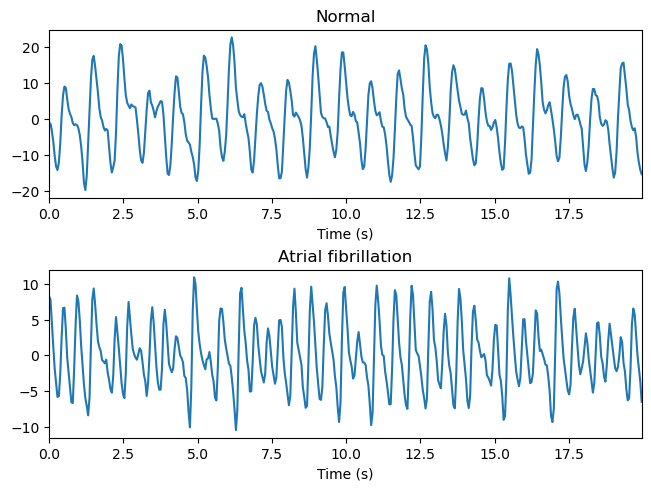

In [73]:
with open(fppg, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    ppg1 = np.array([float(s[0]) for s in txt])
    ppg2 = np.array([float(s[1]) for s in txt])

for y in [ppg1, ppg2]:
    y -= np.mean(y)

fs = 21.3 # Hz

plt.figure(constrained_layout=True)
ttl = ['Normal', 'Atrial fibrillation']

n = len(ppg1)
t = np.arange(n) / fs

for k in range(2):
    
    y = [ppg1, ppg2][k]
    
    plt.subplot(2,1,k+1)
    plt.plot(t, y)
    plt.xlim(t[0], t[-1])
    plt.xlabel('Time (s)')
    plt.title(ttl[k])

Each observed oscillation on the PPG typically corresponds to one pulse, generated by one cardiac cycle. By inspecting the plot above, we can already appreciate how one signal is visibly less regular than the other. AR modeling allows us to quantify the underlying differences with several complementary metrics.

We define again the function `ar_order` introduced in the previous practical session:

In [74]:
def ar_order(x, omax, Aff=0):
    """
    AR order estimation
    x: signal
    omax: maximum possible order
    Aff: 0 no graphic display; 1 display
    
    Returns:
    omdl: order estimated with MDL
    """
    
    nx = len(x)
    s = np.zeros((omax,))
    c = np.zeros((omax,))

    for k in range(omax):
        
        n = k+1
        
        ar_model = AutoReg(x, n, trend='n')
        ar_model_fit = ar_model.fit()
        sg2 = ar_model_fit.sigma2
        
        s[k] = sg2
        c[k] = nx * np.log(sg2) + (n+1) * np.log(nx)

    if Aff == 1:
        plt.figure()
        plt.plot(range(1, omax+1), c, 'o-')
        plt.title('Criterion')
        plt.show()
    
    print('The optimal AR model order is', np.argmin(c)+1)
    return np.argmin(c)+1, s, c

**Question 3.1.** Estimate the optimal AR model order for each signal, using the function `ar_order` above (you can set a maximal order of 40 for the search).

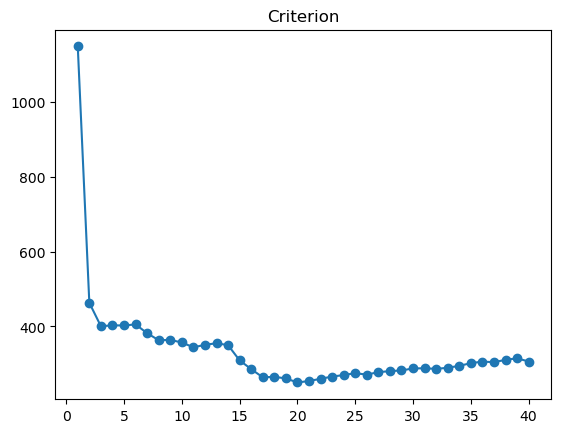

The optimal AR model order is 20


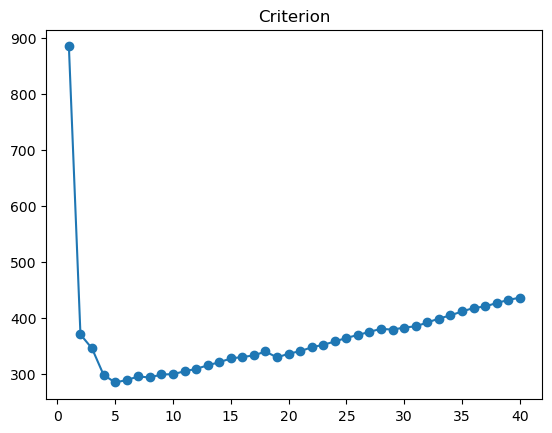

The optimal AR model order is 5


(5,
 array([7.75961553, 2.2860707 , 2.12581478, 1.87582713, 1.79125585,
        1.78411005, 1.78547061, 1.75282895, 1.7498766 , 1.72760607,
        1.72369599, 1.71659186, 1.71794595, 1.71568229, 1.71846613,
        1.7047093 , 1.69184561, 1.69580385, 1.63047948, 1.63299181,
        1.62706346, 1.63042599, 1.62422247, 1.62382646, 1.62501548,
        1.62211476, 1.62009216, 1.61818111, 1.58912276, 1.58108782,
        1.56642757, 1.56952266, 1.57286622, 1.57178292, 1.57529422,
        1.57557698, 1.56349629, 1.56384152, 1.56166188, 1.5546324 ]),
 array([884.95424636, 370.39481214, 345.48785389, 298.24736721,
        284.64926257, 289.00087583, 295.38005739, 293.5743719 ,
        298.91067939, 299.50865782, 304.59784126, 308.89291168,
        315.28325969, 320.77600732, 327.52110796, 330.15156699,
        332.97923184, 340.02917714, 329.34916747, 336.05950569,
        340.56459625, 347.49850992, 351.92899237, 357.87955521,
        364.24581037, 369.5391418 , 375.06207608, 380.61371133,
  

In [75]:
ar_order(ppg1,40,1)
ar_order(ppg2,40,1)

**Answer 3.1.** The AR model orders are respectively 20 and 5.

**Question 3.2.** Estimate the ratio between the excitation variance and the signal variance, for each signal (as in previous exercises, you can rely on the `yule_walker` function with `method='mle'`)

**Answer 3.2.** `Write your answer here`

In [76]:
_, sg_one = yule_walker(ppg1, order=20, method="mle")
_, sg_two = yule_walker(ppg2, order=5, method="mle")

excit_var_one = np.power(sg_one, 2)
excit_var_two = np.power(sg_two, 2)

sig_var_one = np.var(ppg1)
sig_var_two = np.var(ppg2)

ratio_one = excit_var_one / sig_var_one
ratio_two = excit_var_two / sig_var_two

print("The ratio of the excitation variance to the signal variance for the first PPG signal (Normal case) is", ratio_one)
print("The ratio of the excitation variance to the signal variance for the second PPG signal (AF) is", ratio_two)


The ratio of the excitation variance to the signal variance for the first PPG signal (Normal case) is 0.027664189552700818
The ratio of the excitation variance to the signal variance for the second PPG signal (AF) is 0.10872695890695387


**Question 3.3.** Estimate and plot the PSD of each signal, using the `ar_psd` function for the estimates (for consistency, use the same order of 20 for both signals)

**Answer 3.3.** 

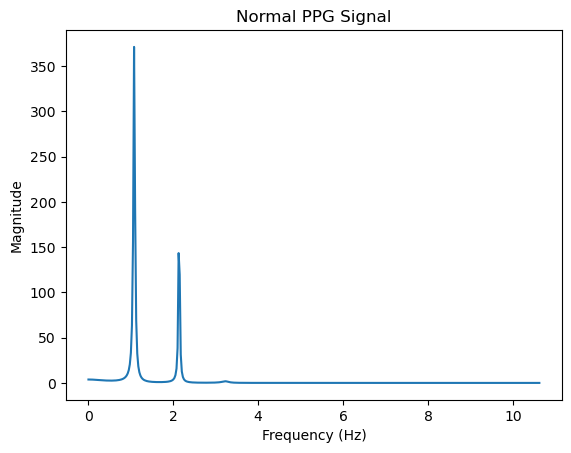

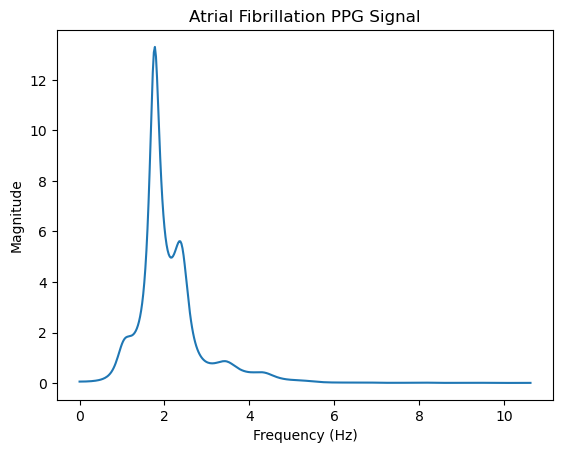

In [77]:
py, f = ar_psd(ppg1, 20, fs, n)
plt.figure()
plt.plot(f, py)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Normal PPG Signal')
plt.show()

py2, f2 = ar_psd(ppg2, 20, fs, n)
plt.figure()
plt.plot(f2, py2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Atrial Fibrillation PPG Signal')
plt.show()

**Question 3.4.** Estimate the entropy of the PSD of each signal, using:

*p = py / sum(py)*

*entropy = sum(-p * log(p))*

where py is the vector of PSD amplitudes.

**Answer 3.4.**


In [78]:
def entropy_psd(py):
    p = py / np.sum(py)
    H = np.sum(-p * np.log2(p))
    
    return H

H1 = entropy_psd(py)
H2 = entropy_psd(py2)
print("The entropy of the power spectral density of the normal PPG signal is", H1)
print("The entropy of the power spectral density of the atrial fibrillation PPG signal is", H2)

The entropy of the power spectral density of the normal PPG signal is 4.557133908405618
The entropy of the power spectral density of the atrial fibrillation PPG signal is 6.709068363910199


**Question 3.5.** What do these measures (model order, variance ratio, PSD, entropy) tell us about the two signals? Interpret what you have obtained in terms of signal structure/organization.

**Answer 3.5.** 
 
- Higher entropy (AF case) indicates a less structured, less interpretable signal with more randomness

- Lower entropy (Normal case) represents a more structured and readable signal

- The normal case's PPG case has an order of 20, meaning a higher degree of structure and readability and more dependency on previous values of the signal.

- The atrial fibrillation (AF) case shows an order of 5, reflecting less structure in the signal.

- The variance ratio in the normal PPG case is lower, indicating that the excitation variance has less impact on the signal compared to the AF case.

- The PSD for the normal PPG signal has two distinct peaks—one around 1 Hz and a harmonic near 2 Hz. In contrast, the AF case shows a more spread-out spectrum with a broader peak (a sharp one shortly before 2 Hz, and a smaller one shortly after 2 Hz), lacking the sharp definition of the normal case. This highlights the well-regulated heartbeat in the normal case versus the irregularity in the AF case.

### Experiment 4: Pisarenko harmonic estimation of brain signals
The file `/data/eeg_stim.dat` contains three recordings of scalp electroencephalography (EEG; left frontal electrode, 4-s duration, 512 Hz sampling frequency) from a Parkinson's patient. The patient was also implanted with a deep brain stimulation (DBS) electrode. The first recording corresponds to a baseline (rest) state, the second was obtained during 1-Hz stimulation, and the third during 100-Hz stimulation.

We start by importing and plotting the three signals:

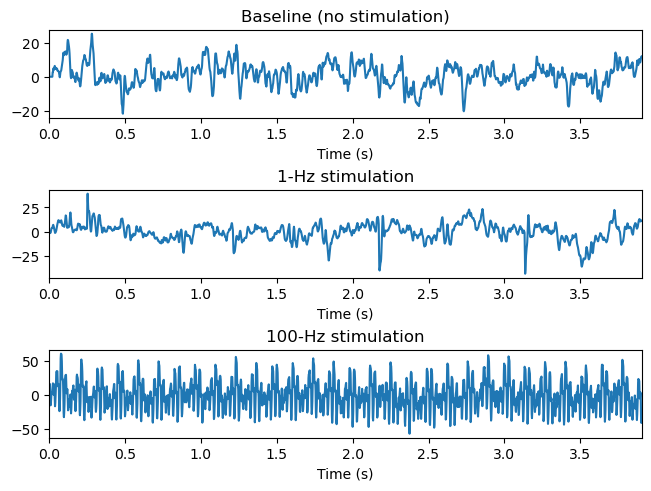

In [80]:
with open(feeg, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    eeg = np.zeros((n,3))
    for k in range(3):
        eeg[:,k] = [float(s[k]) for s in txt]

fs = 512.0 # Hz

plt.figure(constrained_layout=True)
ttl = ['Baseline (no stimulation)', '1-Hz stimulation', '100-Hz stimulation']

t = np.arange(n) / fs

for k in range(3):
    plt.subplot(3,1,k+1)
    plt.plot(t, eeg[:,k])
    plt.xlim(t[0], t[-1])
    plt.xlabel('Time (s)')
    plt.title(ttl[k])

**Question 4.1.** Visually, does any of the stimulation strategies appear to have an effect on the EEG? Which one(s)?

**Answer 4.1.** 
Visually, we can see that both the 1-Hz and 100-Hz stimulations have a noticeable effect on the EEG signal compared to the no-stimulation case.

In the no-stimulation (baseline) signal, the amplitude is low, and the signal appears random, without a clear structure or periodicity.
With 1-Hz stimulation, the signal becomes slightly less random, but it still remains relatively unstructured and difficult to interpret.

When the stimulation increases to 100 Hz, we observe a significant increase in both amplitude and regularity. The signal now shows clear periodicity and a more structured pattern.

Therefore, the 100-Hz stimulation has the strongest effect, creating a more organized and periodic signal compared to the 1-Hz stimulation or the baseline.

As in previous examples, we can apply modeling techniques to quantify the physiological effects under study. Because the DBS is applied in a periodic regime with a specific frequency, it is reasonable to expect a strong sinusoidal presence on the EEG recordings, for any cases where the stimulation does produce a measurable effect. This motivates applying the Pisarenko harmonic retrieval approach, which is implemented below:

In [23]:
def pisarenko(x, p, fs, Aff=0):
    """
    Pisarenko method for harmonic retrieval
    
    x: signal
    p: number of sinusoids
    fs: sampling frequency
    Aff: 0 no graphic display; 1 display
    
    f: vector of sinusoid frequencies
    pp: vector of sinusoid amplitudes
    sg2: noise variance
    
    """
    
    n = len(x)
    
    rx = correlate(x, x, mode='full', method='auto') / n
    
    rxx = np.zeros((2*p+1,2*p+1))
    for k1 in range(2*p+1):
        for k2 in range(2*p+1):
            rxx[k1,k2] = rx[n-1 + abs(k1 - k2)]
    
    u, v = np.linalg.eig(rxx)
    
    sg2 = np.min(u)
    vm = v[:,np.argmin(u)]  # get eigenvector from smallest eigenvalue
    
    r = np.roots(vm)  # find roots of the polynomial
    f = np.angle(r) / (2*np.pi)  # get angle and convert to Hz/sample
    f = f[f > 0]
    
    # Amplitude estimation
    aa = np.zeros((p, len(f)))
    for k in range(p):
        aa[k,:] = np.cos(2*np.pi * (k+1) * f)
    
    r = rx[n:n+p]
    
    pp = np.linalg.lstsq(aa, r, rcond=None)[0]
    f *= fs
    
    if Aff:
        
        plt.figure(constrained_layout=True)
        
        plt.subplot(2,1,1)
        plt.plot(np.arange(1,n+1) / fs, x)
        plt.xlabel('Time (s)')
        plt.title('Signal')
        
        plt.subplot(2,1,2)
        plt.plot([0, fs/2], [sg2, sg2], linewidth=2)
        for k in range(p):
            plt.plot([f[k], f[k]], [sg2, sg2+pp[k]], linewidth=2)
        plt.axis([0, fs/2, 0, 1.2 * (np.max(pp) + sg2)])
        plt.xlabel('Frequency (Hz)')
        plt.title('Pisarenko spectrum')
    
    return f, pp, sg2

**Question 4.2.** Using the above function, apply the Pisarenko method with 5 sinusoids to each of the three recordings, and report the estimated parameters (frequencies, amplitudes, excitation variance).

**Answer 4.2.**

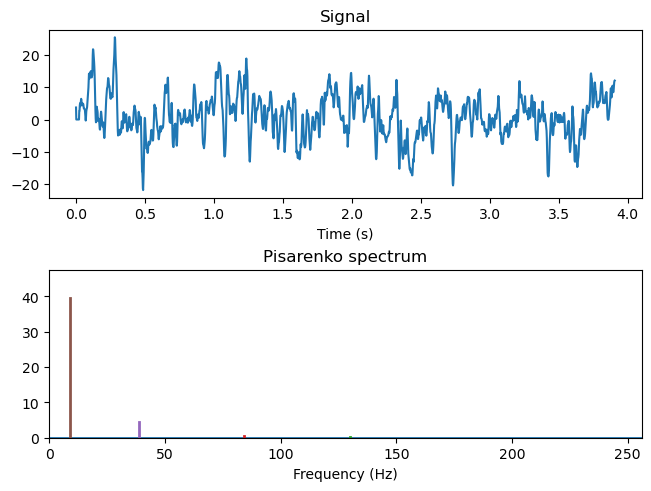

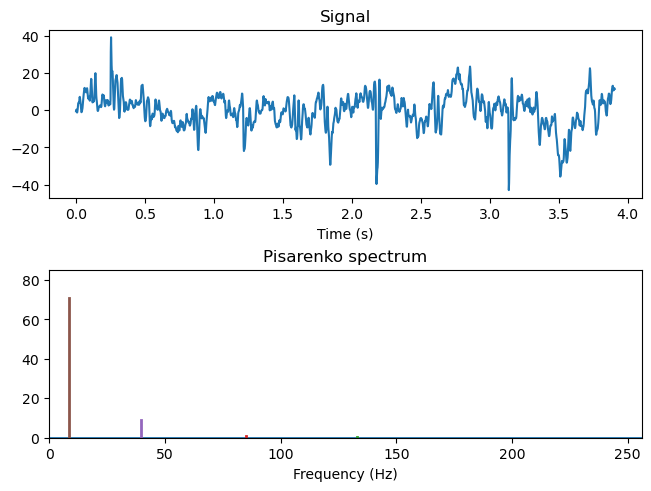

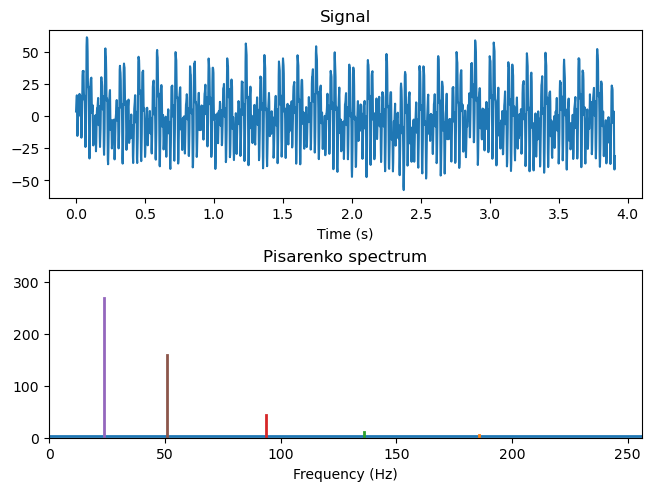

In [81]:
f_no, pp_no, sg2_no = pisarenko(eeg[:,0], 5, fs, 1)
f2_onehz, pp2_onehz, sg22_onehz = pisarenko(eeg[:,1], 5, fs, 1)
f3_hundredhz, pp3_hundredhz, sg23_hundredhz = pisarenko(eeg[:,2], 5, fs, 1)


In [25]:
data = {
    ('Baseline (no stimulation)', 'Frequency (Hz)'): f_no,
    ('Baseline (no stimulation)', 'Amplitude'): pp_no,
    ('Baseline (no stimulation)', 'Noise variance'): sg2_no,
    ('1-Hz stimulation', 'Frequency (Hz)'): f2_onehz,
    ('1-Hz stimulation', 'Amplitude'): pp2_onehz,
    ('1-Hz stimulation', 'Noise variance'): sg22_onehz,
    ('100-Hz stimulation', 'Frequency (Hz)'): f3_hundredhz,
    ('100-Hz stimulation', 'Amplitude'): pp3_hundredhz,
    ('100-Hz stimulation', 'Noise variance'): sg23_hundredhz
}

df = pd.DataFrame(data)
df['Sinusoid number'] = np.arange(1,6)
df.set_index('Sinusoid number', inplace=True)
df

Baseline (no stimulation)                            \
                           Frequency (Hz)  Amplitude Noise variance   
Sinusoid number                                                       
1                              177.971940   0.007938       0.032894   
2                              130.103110   0.057800       0.032894   
3                               84.361503   0.392010       0.032894   
4                               38.888120   4.333258       0.032894   
5                                9.022984  39.626407       0.032894   

                1-Hz stimulation                           100-Hz stimulation  \
                  Frequency (Hz)  Amplitude Noise variance     Frequency (Hz)   
Sinusoid number                                                                 
1                     181.140917   0.026854       0.061209         185.887427   
2                     132.825378   0.156214       0.061209         136.091924   
3                      85.028989   1.051686       0.061209          93.569855   
4                      39.608545   9.018498       0.061209          23.536585   
5                       8.725521  70.993153       0.061209          50.791923   

                                            
                  Amplitude Noise variance  
Sinusoid number                             
1                  1.335573       3.762942  
2                  7.673892       3.762942  
3                 39.284430       3.762942  
4                265.726863       3.762942  
5                154.961058       3.762942

**Question 4.3.** Interpret the estimation results -- which stimulation frequency appears to effectively influence brain activity?

**Answer 4.3.** 

The amplitude is increasing rapidly in the 100 Hz simulation, resulting in larger amplitudes compared to the other two cases. 

Frequency values are decreasing across all three cases, the 100 Hz simulation maintains the highest frequency. 

The noise variance is significantly greater in the 100 Hz simulation.

**Réponse de Caspar**

From the dataframe above, one can notice that with a stimulation frequency of 1 Hz, there is a single huge peak in amplitude for the sinusoid with a 9 Hz frequency, which is the same lone peak that we notice in the baseline. Since both the baseline and the 1 Hz stimulation frequency data have a similar profile, we can deduce that this stimulation frequency does not affect brain activity very much.

On the contrary, there are three distinct peaks in amplitude with a stimulation frequency of 100 Hz, meaning that the brain activity appears to be much more influenced by this stimulation frequency. The variance in this case is also higher.



### Have a good session, and don't hesitate to ask questions!